In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import requests

2024-04-01 21:22:12.259202: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 21:22:12.279485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 21:22:12.279506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 21:22:12.280007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 21:22:12.283528: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import requests

base_url = "http://environment.data.gov.uk/hydrology/id/"


def get_active_stations(observed_property):
    """Retrieve active monitoring stations for a specific observed property (e.g., waterFlow or waterLevel)."""
    endpoint = f"{base_url}stations"
    params = {
        'status.label': 'Active',
        'observedProperty': observed_property,
        '_limit': 10000  # Increase limit as needed

    }
    response = requests.get(endpoint, params=params)
    return response.json()


def get_station_measures_by_guid(station_guid):
    """Retrieve available measures for a specific station."""
    endpoint = f"{base_url}measures"
    params = {
        'station': station_guid
    }
    response = requests.get(endpoint, params=params)
    data = response.json()
    return data


def get_active_stations_count(observed_property):
    """Retrieve counts of active monitoring stations with and without NRFA IDs for a specific observed property."""
    endpoint = f"{base_url}stations"
    params = {
        'status.label': 'Active',
        'observedProperty': observed_property,
        '_limit': 10000  # Assuming a high limit to fetch all relevant stations
    }
    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        data = response.json()
        total_stations = len(data['items'])
        stations_with_nrfa = sum('nrfaStationID' in station for station in data['items'])
        stations_without_nrfa = total_stations - stations_with_nrfa

        return {
            "total_stations": total_stations,
            "stations_with_nrfa": stations_with_nrfa,
            "stations_without_nrfa": stations_without_nrfa
        }
    else:
        return f"Error: {response.status_code}"


observed_property = "waterLevel"  # or "waterFlow", etc.
station_counts = get_active_stations_count(observed_property)


In [3]:
def get_station_info(id):
    endpoint = f"{base_url}stations/{id}"
    
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()
    else:
        return f"Error: {response.status_code}"

In [4]:
import requests

def get_station_detailed_info_from_ref(station_id):
    
    # Endpoint to get basic station info
    initial_endpoint = f"{base_url}stations/{station_id}.json"
    
    # Make the initial API call to get the basic station information
    initial_response = requests.get(initial_endpoint)
    if initial_response.status_code == 200:
        initial_data = initial_response.json()
        
        # Assuming 'stationReference' can be directly extracted from the initial response
        # Here we adjust based on your data structure, ensuring we access the correct field
        station_reference = initial_data['items'][0]['stationReference'] if 'items' in initial_data and len(initial_data['items']) > 0 else None
        
        if station_reference:
            # Construct the URL manually using the station reference
            detailed_url = f"https://environment.data.gov.uk/flood-monitoring/id/stations/{station_reference}"
            
            # Make a second API call to the manually constructed URL to get detailed station information
            detailed_response = requests.get(detailed_url)
            if detailed_response.status_code == 200:
                detailed_data = detailed_response.json()
                
                # Extract the typical range high and low from the detailed data
                typical_range_high = detailed_data['items']['stageScale']['typicalRangeHigh']
                typical_range_low = detailed_data['items']['stageScale']['typicalRangeLow']
                
                return {
                    "typicalRangeHigh": typical_range_high,
                    "typicalRangeLow": typical_range_low
                }
            else:
                return f"Error fetching detailed info: {detailed_response.status_code}"
        else:
            return "Station reference not found in initial response."
    else:
        return f"Error fetching initial info: {initial_response.status_code}"



In [5]:
stations_response = get_active_stations('waterLevel')

def create_id_map(data):
    id_map = []
    for item in data['items']:
        entry = {
            "guid": item['stationGuid'],
            "nrfa": item.get('nrfaStationID', 'N/A'),  # Using .get() for safe access
            "wiski": item.get('wiskiID', 'N/A')
        }
        id_map.append(entry)
    return id_map

def get_guid_by_nrfa_id(nrfa_id, mapping):
    """
    Retrieve the GUID for a given NRFA ID from the mapping list.

    Parameters:
    - nrfa_id (str): The NRFA ID to search for.
    - mapping (list): The list containing mappings of GUID, NRFA, and Wiski IDs.

    Returns:
    - str: The GUID corresponding to the given NRFA ID, or None if not found.
    """
    nrfa_id_str = str(nrfa_id)
    for item in mapping:
        if item['nrfa'] == nrfa_id_str:
            return item['guid']
    return None

station_ids = create_id_map(stations_response)
# print(station_ids)

# Assume you choose a station and want to get measures for it
station_id = 21035
station_guid = get_guid_by_nrfa_id(station_id, station_ids)

# print(f"station_guid = {station_guid}")
station_measures = get_station_measures_by_guid(station_guid)
print(station_measures)
# station_info = get_station_info(station_guid)
# # print(station_measures)
# print(station_info)
station_info = get_station_detailed_info_from_ref(station_guid)
print(station_info)

{'meta': {'@id': 'http://environment.data.gov.uk/hydrology/id/measures?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'publisher': 'Environment Agency', 'license': 'http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/', 'licenseName': 'OGL 3', 'comment': 'Hydrology API for sub-daily data', 'version': '2.0.0', 'hasFormat': ['http://environment.data.gov.uk/hydrology/id/measures.html?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.ttl?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.csv?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.rdf?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.json?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.geojson?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1']}, 'items': [{'@id'

In [6]:
def generate_csv_urls(measures_data):
    """Generate CSV URLs for daily measures (flow and level min, max, mean) with specific measurement type."""
    csv_urls = []
    for item in measures_data['items']:
        if item.get('period') == 900:
            parameter_name = item.get('parameterName', '').lower()
            # Creating more specific identifiers for column names
            if 'flow' in parameter_name:
                prefix = 'f'  # Shorten flow to 'f'
            elif 'level' in parameter_name:
                prefix = 'l'  # Shorten level to 'l'
            else:
                continue  # Skip if neither flow nor level

            valueType = item.get('valueType', '').lower()
            if valueType:  # Append valueType (min, max, mean) if present
                specific_name = f"{prefix}{valueType}"
            else:
                specific_name = prefix

            measure_id_url = item['@id']
            csv_url = f"{measure_id_url}/readings.csv"
            csv_urls.append((csv_url, specific_name))
    return csv_urls


def load_csv_data_to_dataframe(csv_urls):
    """Load CSV data from URLs into Pandas DataFrame, using the 'dateTime' column for 15-minute intervals."""
    dfs = []
    for url, parameterName in csv_urls:
        # Use 'dateTime' column instead of 'date', assuming 'dateTime' exists in your CSV
        df = pd.read_csv(url, usecols=['dateTime', 'value'])
        # Rename the 'value' column to match the parameterName for clarity
        df.rename(columns={'value': parameterName}, inplace=True)
        # Ensure 'dateTime' is in datetime format for easy handling
        df['dateTime'] = pd.to_datetime(df['dateTime'])
        dfs.append(df)

    # Assuming all dfs have a 'dateTime' column, merge them on this column
    if dfs:
        combined_df = dfs[0]
        for df in dfs[1:]:
            combined_df = pd.merge(combined_df, df, on='dateTime', how='outer')

        # Sort by dateTime to maintain chronological order
        combined_df.sort_values(by='dateTime', inplace=True)
        combined_df.reset_index(drop=True, inplace=True)
        combined_df.set_index('dateTime', inplace=True)
        
        return combined_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data is provided



In [7]:
csv_urls = generate_csv_urls(station_measures)
print(csv_urls)
final_df = load_csv_data_to_dataframe(csv_urls)

[('http://environment.data.gov.uk/hydrology/id/measures/20152e19-e61b-40ff-ae0a-bfd520b41ad1-flow-i-900-m3s-qualified/readings.csv', 'finstantaneous'), ('http://environment.data.gov.uk/hydrology/id/measures/20152e19-e61b-40ff-ae0a-bfd520b41ad1-level-i-900-m-qualified/readings.csv', 'linstantaneous')]


In [8]:
print(final_df.tail)

df = final_df.dropna()

print(df.head())
print(df.tail())

<bound method NDFrame.tail of                      finstantaneous  linstantaneous
dateTime                                           
2001-11-22 15:15:00            9.99           0.591
2001-11-22 15:30:00            9.96           0.590
2001-11-22 15:45:00           10.00           0.592
2001-11-22 16:00:00            9.89           0.588
2001-11-22 16:15:00            9.85           0.587
...                             ...             ...
2004-09-29 06:00:00             NaN           0.275
2004-09-29 06:15:00             NaN           0.275
2004-09-29 06:30:00             NaN           0.276
2004-09-29 06:45:00             NaN           0.275
2004-09-29 07:00:00             NaN           0.276

[142448 rows x 2 columns]>
                     finstantaneous  linstantaneous
dateTime                                           
2001-11-22 15:15:00            9.99           0.591
2001-11-22 15:30:00            9.96           0.590
2001-11-22 15:45:00           10.00           0.592
2001-1

In [9]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

data = df.values

scaler = MinMaxScaler(feature_range=(0,1))
data_normalised = scaler.fit_transform(data)

n_input = 96 # Number of input data required for prediction - number of previous 15 minute intervals
n_output = 24 # Number of predicted 15 min intervals based on past data (6 hours prediction)
n_features = 2
batch_size = 32 

# Split data into training and test sets (70% training, 30% testing)
split_percent = 0.95
split_index = int(len(data_normalised) * split_percent)

train_data = data_normalised[:split_index]
test_data = data_normalised[split_index - n_input:]

lmax_index = 1 #Index for the target columne - we are targetting max level of the river - lmax 

#Generators:
train_generator = TimeseriesGenerator(train_data, train_data[:,lmax_index], length=n_input, batch_size=batch_size, stride=1, sampling_rate=1)
test_generator = TimeseriesGenerator(test_data, test_data[:, lmax_index], length=n_input, batch_size=batch_size, stride=1, sampling_rate=1)

# Print some generator details to confirm setup
for i, (x, y) in enumerate(train_generator):
    print(f"Batch {i}:")
    print(f"X shape: {x.shape}, Y shape: {y.shape}")
    # Print details for the first batch and break
    if i == 0:
        break

Batch 0:
X shape: (32, 96, 2), Y shape: (32,)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # LSTM layer with 50 units, input shape based on generator's settings
    LSTM(128, return_sequences=True,  input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(64, return_sequences=False), 
    Dropout(0.2),
    Dense(n_output)
])

# model = Sequential([
#     GRU(256, return_sequences=False, input_shape=(n_input, n_features)), 
#     Dropout(0.2),
#     Dense(n_output)
# ])

# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=0.005)) # Huber selected for higher sensitivity to outliers than MSE
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
# Summary of the model
model.summary()

# Define EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train the model
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=10,
                    callbacks=[early_stopping])

2024-04-01 21:22:44.575000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 21:22:44.587064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 21:22:44.587098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 21:22:44.589345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 21:22:44.589378: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 96, 128)           67072     
                                                                 
 dropout (Dropout)           (None, 96, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
Total params: 118040 (461.09 KB)
Trainable params: 118040 (461.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2024-04-01 21:22:46.246111: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-01 21:22:46.639177: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3c240099a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-01 21:22:46.639203: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-01 21:22:46.642231: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712002966.696005   38288 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1706/1706 [==============================] - 22s 12ms/step - loss: 5.6907e-05 - val_loss: 5.7297e-07
Epoch 2/10
1706/1706 [==============================] - 20s 12ms/step - loss: 2.5844e-05 - val_loss: 8.0627e-07
Epoch 3/10
1706/1706 [==============================] - 20s 12ms/step - loss: 2.2749e-05 - val_loss: 1.2970e-05
Epoch 4/10
1706/1706 [==============================] - 20s 12ms/step - loss: 2.3453e-05 - val_loss: 6.0167e-06
Epoch 5/10
1706/1706 [==============================] - 21s 12ms/step - loss: 2.0997e-05 - val_loss: 2.1910e-07
Epoch 6/10
1706/1706 [==============================] - 28s 16ms/step - loss: 2.0143e-05 - val_loss: 3.4499e-07
Epoch 7/10
1706/1706 [==============================] - 28s 16ms/step - loss: 1.9594e-05 - val_loss: 3.0764e-06
Epoch 8/10
1706/1706 [==============================] - 27s 16ms/step - loss: 2.0247e-05 - val_loss: 6.3730e-07
Epoch 9/10
1706/1706 [==============================] - 28s 17ms/step - loss: 2.0178e-05 - val_loss: 1.4518e-06
Epo

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a 'scaler' object used for normalization
# and 'test_generator' that was used for testing the model

# Generate predictions for the test data
predictions = model.predict(test_generator)

predictions_reshaped = predictions.reshape(-1, 1)

# Collect the actual y values from the test generator
actuals = []
for _, y in test_generator:
    actuals.extend(y)
y_test = np.array(actuals)

y_test_reshaped = y_test.reshape(-1, 1)

90/90 [==============================] - 1s 8ms/step


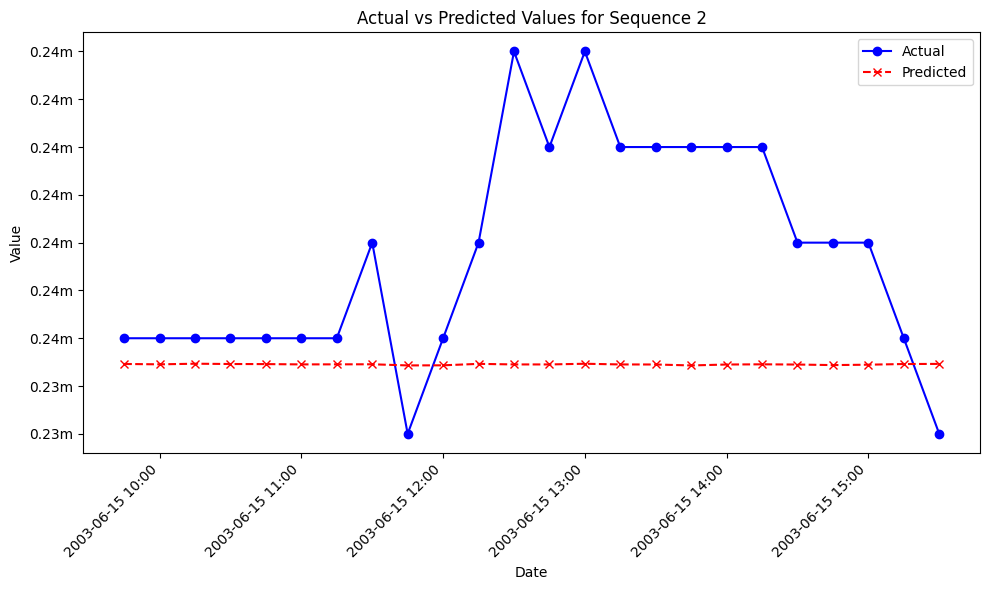

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter


# Assuming:
# - `predictions` is your model output with shape (num_sequences, prediction_length)
# - `actuals` is a flattened array of actual values of length 'n'
# - `scaler` is the MinMaxScaler instance used for scaling the dataset
# - `df` is the original DataFrame used for model training and testing
# - `lmax_index` is the column index in the DataFrame corresponding to the predicted feature
# - `split_index` is the index where the test data starts in the original DataFrame
# - `n_output` is the number of steps predicted by the model in each sequence

sequence_num = 1# Change this to plot different sequences
prediction_length = n_output

# Reshape predictions to match the scaler's expected input
predictions_reshaped = predictions.reshape(-1, 1)
actuals_reshaped = np.array(actuals).reshape(-1, 1)

# Create dummy arrays for inverse transform
dummy_predictions = np.zeros((len(predictions_reshaped), df.shape[1]))
dummy_actuals = np.zeros((len(actuals_reshaped), df.shape[1]))

# Assuming 'lmax_index' is the index of the feature to predict
dummy_predictions[:, lmax_index] = predictions_reshaped[:, 0]
dummy_actuals[:, lmax_index] = actuals_reshaped[:, 0]

# Inverse transform
predictions_inverse = scaler.inverse_transform(dummy_predictions)[:, lmax_index]
actuals_inverse = scaler.inverse_transform(dummy_actuals)[:, lmax_index]

# Calculate start and end indices for actual values that correspond to this sequence
actual_start_index = sequence_num * prediction_length
actual_end_index = actual_start_index + prediction_length

# Selecting the sequence to plot
sequence_predictions = predictions_inverse[sequence_num * prediction_length:(sequence_num + 1) * prediction_length]
sequence_actuals = actuals_inverse[actual_start_index:actual_end_index]

# Generating dates/timestamps for plotting
dates = pd.date_range(start=df.index[split_index + sequence_num * prediction_length], periods=prediction_length, freq="15min")

# Define a formatter function that takes a value and position and returns the formatted string
def format_y(value, tick_number):
    return f'{value:.2f}m'  # Format the number with three decimal places followed by "m"

# Plot
plt.figure(figsize=(10, 6))
plt.plot(dates, sequence_actuals, label="Actual", marker='o', color='blue')
plt.plot(dates, sequence_predictions, label="Predicted", linestyle='--', marker='x', color='red')

# Formatting the dates on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y))

plt.title(f'Actual vs Predicted Values for Sequence {sequence_num+1}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [13]:
def plot_aggregated_predictions(test_generator, model_predictions, scaler, original_df, n_output, feature_index, split_index, n_input):
    """
    Plots aggregated model predictions against actual values for the entire test dataset,
    taking into consideration the specific feature index for inverse transformation.

    Parameters:
    - test_generator: The generator used for testing the model.
    - model_predictions: Predictions made by the model on the test_generator.
    - scaler: MinMaxScaler instance used to scale the dataset.
    - original_df: Original DataFrame used for the model training and testing.
    - n_output: Number of steps predicted by the model in each sequence.
    - feature_index: Index of the target feature in the original dataset for inverse scaling.
    - split_index: The index where the test data starts in the original DataFrame.
    """
    if model_predictions.ndim > 2:
        model_predictions = model_predictions.reshape(model_predictions.shape[0], -1)
    averaged_predictions = np.mean(model_predictions, axis=1)

    print(f"Model predictions reshaped: {model_predictions.shape}")
    print(f"Averaged predictions: {averaged_predictions.shape}")
    
    # Prepare the dummy array for inverse scaling
    dummy_array = np.zeros((len(averaged_predictions), original_df.shape[1]))
    dummy_array[:, feature_index] = averaged_predictions


    prediction_start_index = split_index + n_input
    prediction_end_index = prediction_start_index + len(averaged_predictions)
    # Inverse transform the dummy array
    predictions_inverse = scaler.inverse_transform(dummy_array)[:, feature_index]
    
    # Trim the prediction data by the initial input of n_input data points. 
    predictions_inverse = predictions_inverse[n_input:]


    print(f"Prediction start index: {prediction_start_index}")
    print(f"Prediction end index: {prediction_end_index}")
    # Prepare the actual values
    # actuals = original_df.iloc[split_index + len(test_generator) - len(averaged_predictions):split_index + len(test_generator), feature_index]
    actuals = original_df.iloc[prediction_start_index:prediction_end_index][original_df.columns[feature_index]]
    print(f"Actuals length: {len(actuals)}")

    # Correctly calculate the start date for the test data predictions
    # This accounts for the 'length' of the test_generator sequences
    test_data_start_date = df.index[prediction_start_index]
    print(f"Test data start date: {test_data_start_date}")


    end_date = df.index[-1]
    
    # Calculate the date range
    date_range_length = pd.date_range(start=test_data_start_date, end=end_date)
    
    # Print the length of the date range
    print(f"Length of date range: {len(date_range_length)}")
    # Generate the date range for plotting, adjusted for the length of averaged_predictions
    prediction_dates = pd.date_range(start=test_data_start_date, periods=actuals.shape[0], freq='15min')
    print(f"Prediction dates length: {len(prediction_dates)}")
    print(f"Length of predictions_inverse: {len(predictions_inverse)}")

    # Plotting code remains the same...
    plt.figure(figsize=(10, 6))
    plt.plot(prediction_dates, actuals.values, label='Actual lmax', color='blue')
    plt.plot(prediction_dates, predictions_inverse, label='Predicted lmax', color='red')
    plt.title('Actual vs Predicted lmax Values')
    plt.xlabel('Date')
    plt.ylabel('lmax Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Model predictions reshaped: (2878, 24)
Averaged predictions: (2878,)
Prediction start index: 54770
Prediction end index: 57648
Actuals length: 2782
Test data start date: 2003-06-16 03:45:00
Length of date range: 29
Prediction dates length: 2782
Length of predictions_inverse: 2782


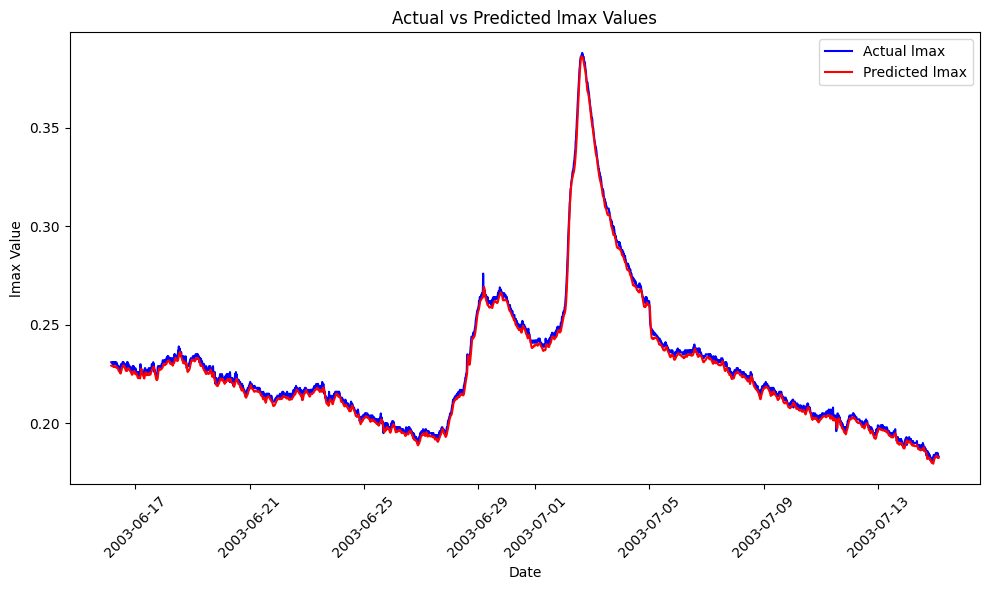

In [14]:
plot_aggregated_predictions(test_generator, predictions, scaler, df, n_output=n_output, feature_index=lmax_index, split_index=split_index, n_input=n_input)

Average RMSE across all sliding windows: 0.0015118075569204598


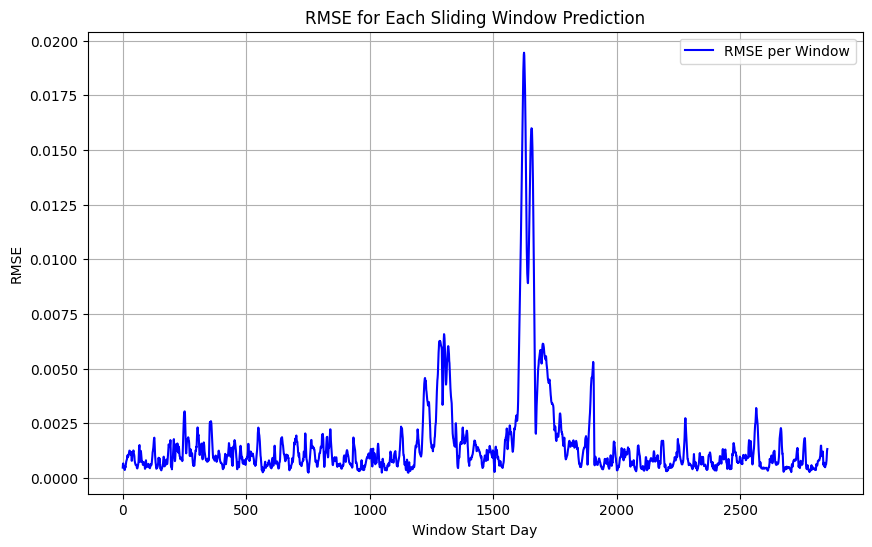

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming you have lists or need to ensure these are numpy arrays
true_values = np.array(actuals)  # Convert to NumPy array if it's not already
predictions = np.array(predictions)  # Convert to NumPy array if it's not already

import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

# Initialize an empty list to store RMSE for each prediction window
rmse_values = []

# Loop through the dataset, aligning each prediction with its corresponding actual values
for i in range(len(true_values) - n_output):
    # Extract the actual values for the next 7 days
    actuals_for_window = true_values[i:i + n_output]

    # Extract the corresponding set of predictions
    predictions_for_window = predictions[i]

    # Calculate the RMSE for this window and append to our list
    rmse = sqrt(mean_squared_error(actuals_for_window, predictions_for_window))
    rmse_values.append(rmse)

# Optionally, calculate the average RMSE across all windows for an overall performance metric
average_rmse = np.mean(rmse_values)

print(f"Average RMSE across all sliding windows: {average_rmse}")

plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(rmse_values, label='RMSE per Window', color='blue')  # Plot RMSE values
plt.title('RMSE for Each Sliding Window Prediction')  # Title of the plot
plt.xlabel('Window Start Day')  # X-axis label
plt.ylabel('RMSE')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot